# Imports

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath("../"))))
sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath("../"))))

from src.explainibility.visualization import dislay_all_explainibility, display_sae_features
from src.explainibility.sae_explainibility import explain_model_with_sae, sae_statistics

from src.model_architecture.SAE.SAE import SaeDecoder, SaeEncoder
from src.model_architecture.cnn_clasifier.cnn_clasifier import CnnKneeClassifier
from torch import optim
import torch
from src.model_training.training_helpers.knee_datasets import KneeScans3DDataset
import torchio as tio
from collections import defaultdict
from src.explainibility.visualization import display_sae_features
from pathlib import Path

# Model and Dataset

In [2]:
model = CnnKneeClassifier(num_classes=3, input_channels=1)
model.load_state_dict(
    torch.load(
        "/home/mikic202/semestr_9/knee_scaner/models/basic_clasifier_model_1766343254.9682245.pth"
    )
)

dataset_transform = tio.transforms.Compose(
    [
        tio.transforms.Resize((64, 64, 64)),
    ]
)

dataset = KneeScans3DDataset(
    datset_filepath="/media/mikic202/Nowy1/uczelnia/semestr_9/SIWY/datasets/kneemri",
    transform=dataset_transform,
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL = model.to(device)
LAYER_TO_EXPLAIN = model.last_feature
LAYER_SIZE = 64 * 16 * 16 * 16

DATASET = dataset
EXAMPLE = DATASET[0][0]
EXAMPLE_CLASS = DATASET[0][1]

# Basic Gradinet Methods

/home/mikic202/semestr_9/knee_scaner/src/explainibility/basic_gradient_based_methods.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(example, dtype=torch.float32).unsqueeze(0)
/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/home/mikic202/semestr_9/knee_scaner/src/explainibility/basic_gradient_based_methods.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(example, dtype=torch.float32).unsqueeze(0)
/home/mikic202

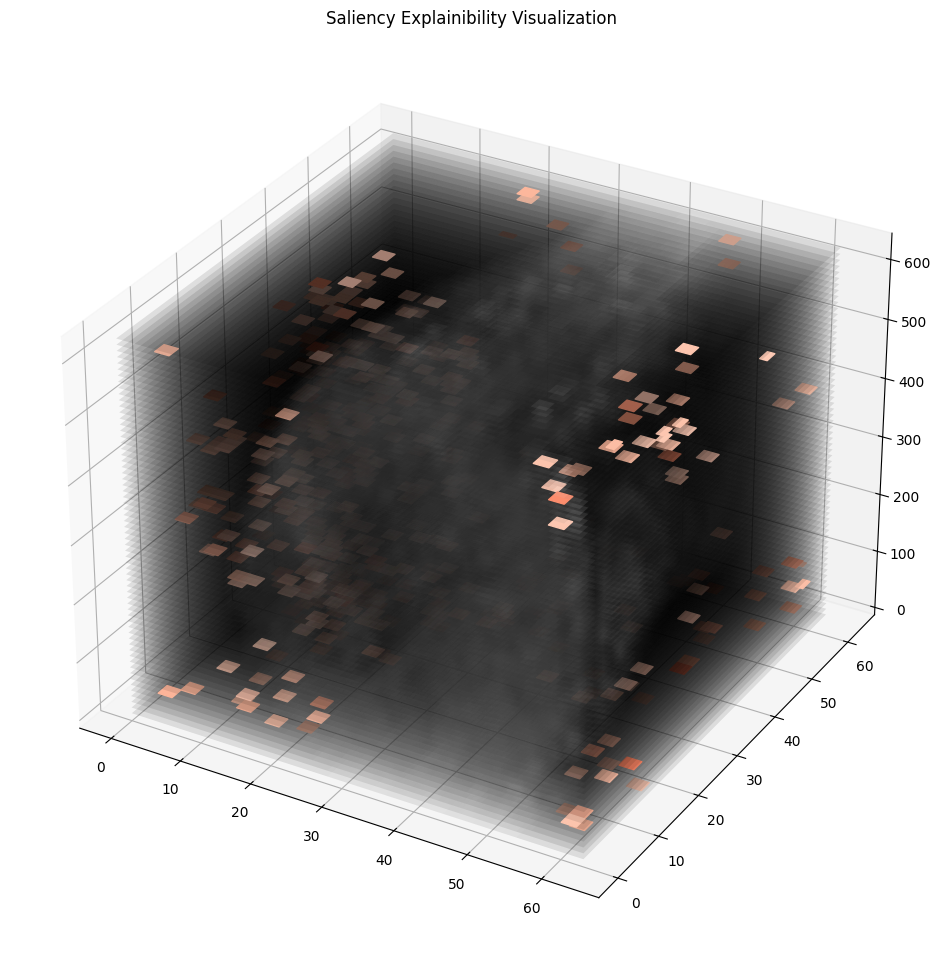

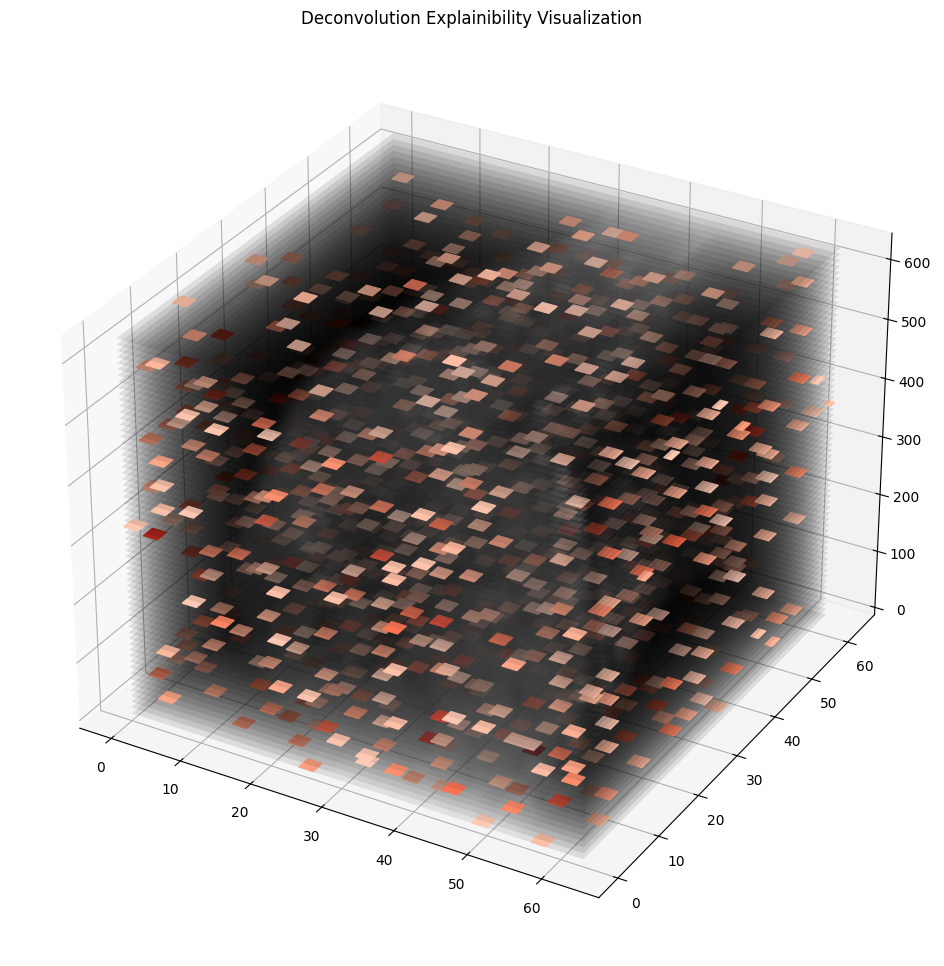

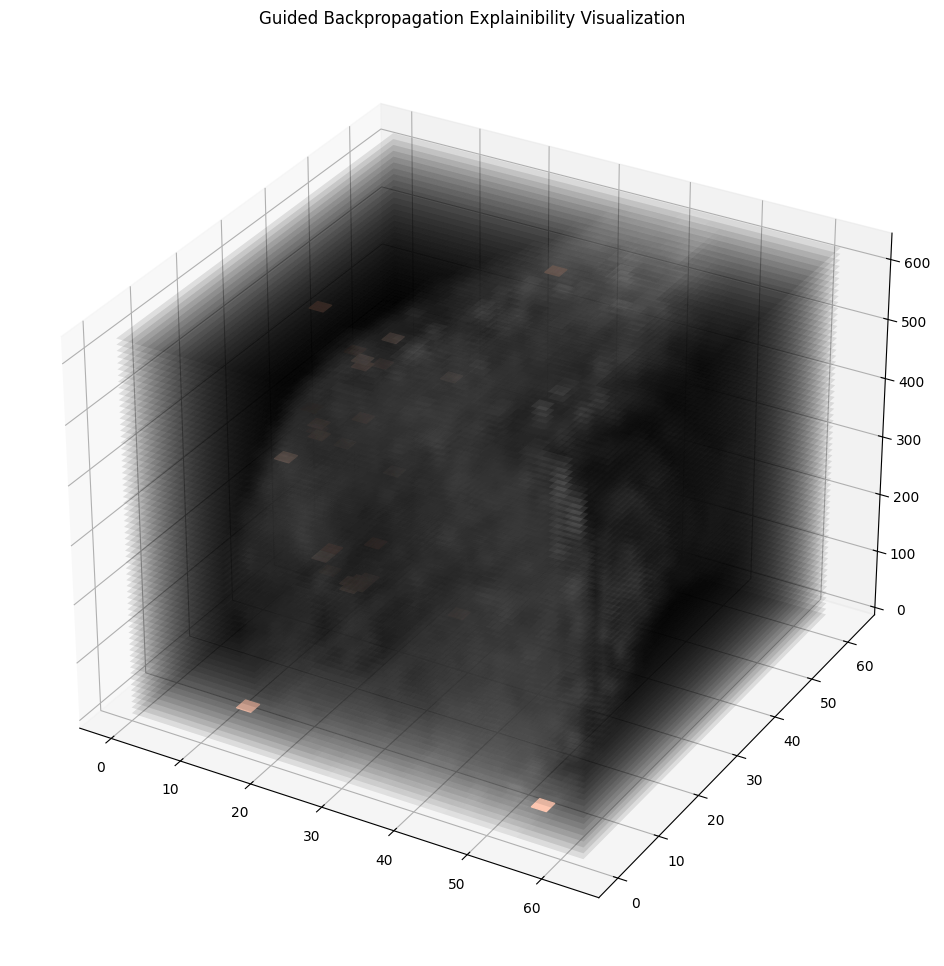

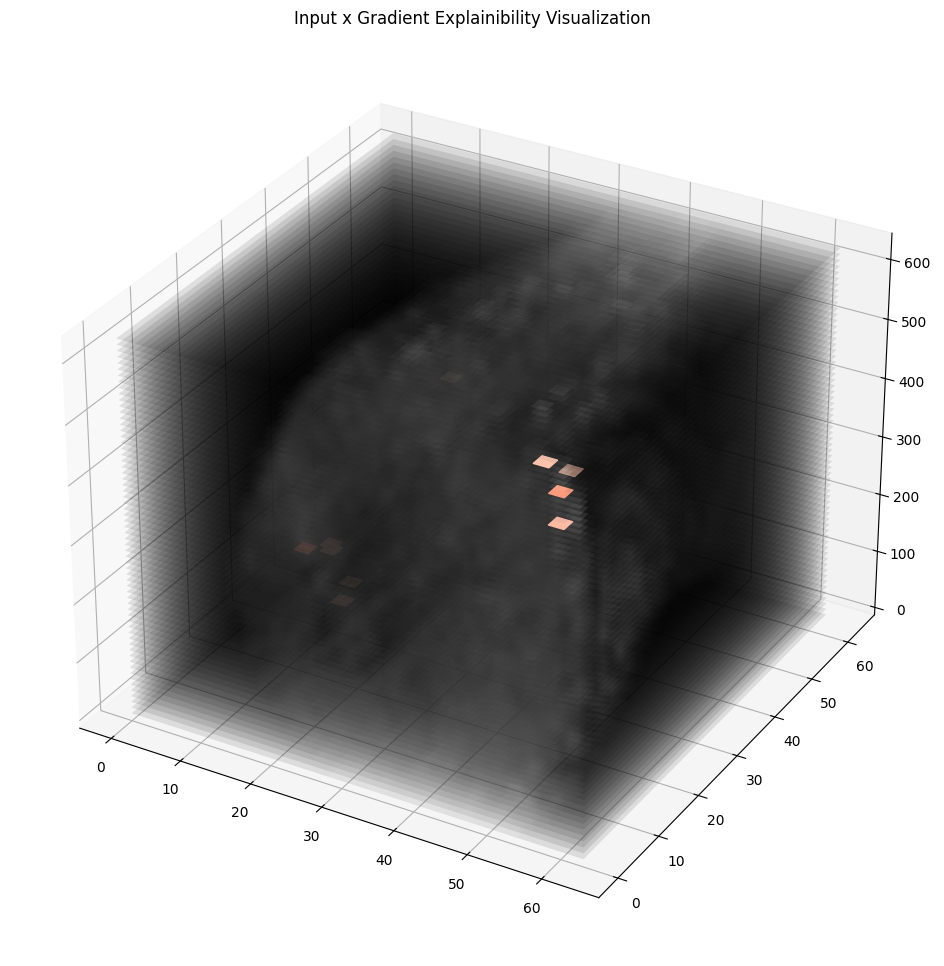

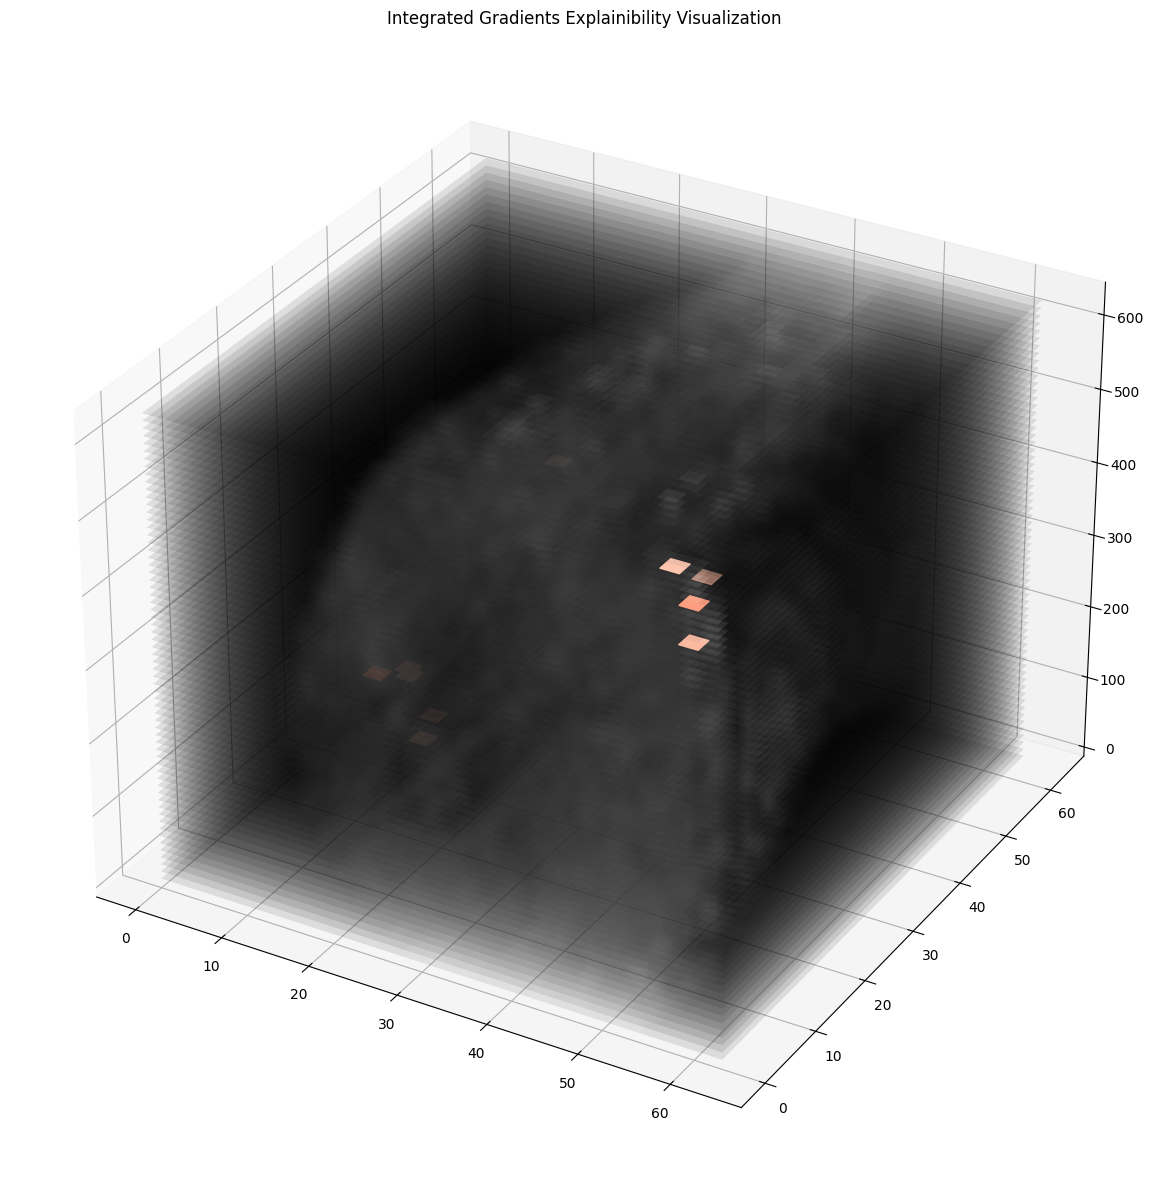

In [8]:
dislay_all_explainibility(model, EXAMPLE, EXAMPLE_CLASS, device)

# GradCam

# SAE

In [4]:
sae_model = explain_model_with_sae(
        MODEL, DATASET, LAYER_TO_EXPLAIN, LAYER_SIZE, 512, 100
    )

sae_features, feature_popularity_order_per_class, feature_counts_per_class = sae_statistics(sae_model, MODEL, LAYER_TO_EXPLAIN, DATASET)


Epoch 1/30, Loss: 41559.9710, sparsity_losss: 1084.9875 
Epoch 2/30, Loss: 24418.7845, sparsity_losss: 1039.0037 
Epoch 3/30, Loss: 15650.9925, sparsity_losss: 1002.4351 
Epoch 4/30, Loss: 11114.0382, sparsity_losss: 1126.9714 
Epoch 5/30, Loss: 8733.2020, sparsity_losss: 1034.8091 
Epoch 6/30, Loss: 7463.4211, sparsity_losss: 1042.2947 
Epoch 7/30, Loss: 6751.2104, sparsity_losss: 1154.4452 
Epoch 8/30, Loss: 6311.5472, sparsity_losss: 1055.7024 
Epoch 9/30, Loss: 6021.2870, sparsity_losss: 1130.9346 
Epoch 10/30, Loss: 5814.5769, sparsity_losss: 1119.4912 
Epoch 11/30, Loss: 5661.2576, sparsity_losss: 1086.9885 
Epoch 12/30, Loss: 5540.4178, sparsity_losss: 1033.6399 
Epoch 13/30, Loss: 5434.6336, sparsity_losss: 1121.9177 
Epoch 14/30, Loss: 5344.5697, sparsity_losss: 931.4638 
Epoch 15/30, Loss: 5259.5124, sparsity_losss: 1075.7048 
Epoch 16/30, Loss: 5180.4872, sparsity_losss: 1056.9498 
Epoch 17/30, Loss: 5110.9970, sparsity_losss: 1075.5244 
Epoch 18/30, Loss: 5042.0339, sparsit

In [5]:
print("Most popular features per class:")
for class_label, feature_order in feature_popularity_order_per_class.items():
    print(f"Class {class_label}: Features {feature_order[:10]}")

Most popular features per class:
Class 0: Features [  0 153 152 135  28 134 132  21 128 111]
Class 1: Features [127  55  28  58  25  73  21  93 111  53]
Class 2: Features [ 0 43 46 53 58 69 73 84 85 93]


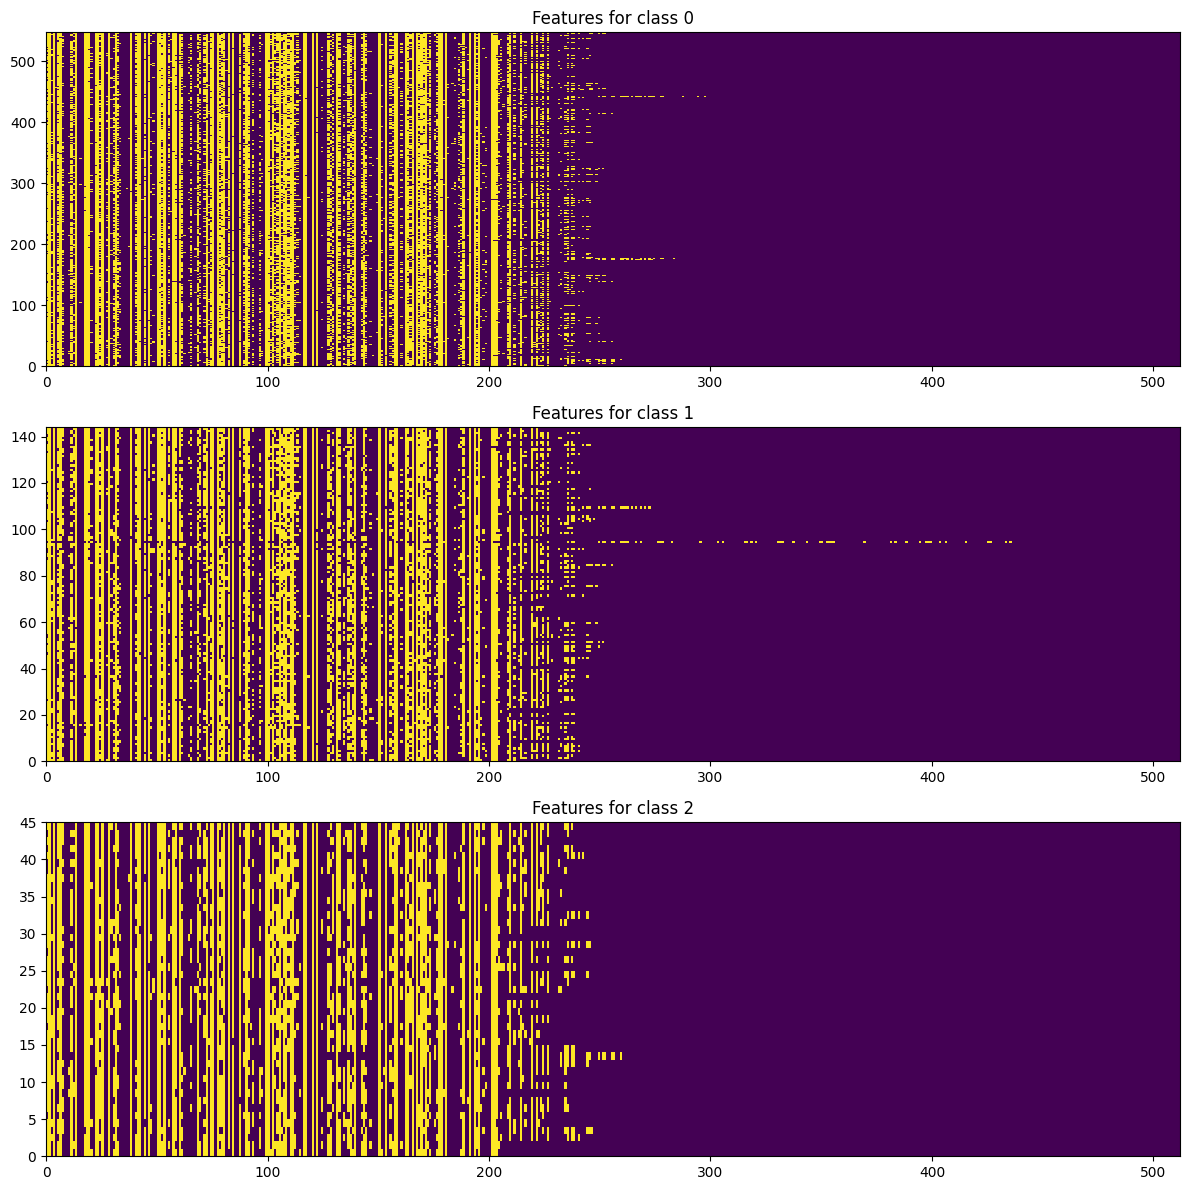

In [5]:
display_sae_features(sae_features, Path(""))